In this lab evaluation we have to do **Amazon pet product reviews classification** .

These are the steps to be done -

1)Load data

2)Perform preprocessing

3)Apply suitable Model and compare results

**Importing the libraries**

In [1]:
#GPU Libraries - these libraries are required for the models we
#are going to apply
import cudf as pd
import cupy as cp
import cuml
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier as cuRFC
from cuml.naive_bayes import MultinomialNB
from cuml.svm import SVC
from cuml.linear_model import LogisticRegression
from cuml.multiclass import MulticlassClassifier
from cuml.multiclass import OneVsRestClassifier

#graph plotting and visualisation library
from matplotlib import pyplot as plt
import seaborn as sns

#Text Preprocessing Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
import re
import string

#deep learning libraries-these libraries also help in preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

**Reading the dataset**

In [2]:
train_df = pd.read_csv('../input/amazonpetproductsreviews/train.csv', index_col='id').fillna(' ')
valid_df = pd.read_csv('../input/amazonpetproductsreviews/valid.csv', index_col='id').fillna(' ')
test_df = pd.read_csv('../input/amazonpetproductsreviews/test.csv', index_col='id').fillna(' ')

We'll be validating with train + validation files.

In [3]:
train_df=pd.concat([train_df, valid_df])

In [4]:
train_df.head()

,text,label
id,,
0,Sam has an everlast treat each nite before bed...,dogs
1,The product is as it says. I keep an eye on it...,dogs
2,My Kitty thinks these are treats! He loves the...,dogs
3,This is the third or fourth time that we've or...,dogs
4,Put this on both my dogs. And they are scratch...,dogs


In [5]:
train_df.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 69410 entries, 0 to 17352
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   text    69410 non-null  object
 1   label   69410 non-null  object
dtypes: object(2)
memory usage: 30.6+ MB


In [6]:
train_df.describe()

,text,label
count,69410,69410
unique,66401,6
top,Length:,dogs
freq,124,37333


In [7]:
train_df.shape

(69410, 2)

In [8]:
test_df.head()

,text
id,
0,Great Filter. I have always used Marineland fi...
1,This is a great item. My elderly dog loves it....
2,"I have a shep/akita mix, but I bought this mor..."
3,I'm always amazed by what is available on Amaz...
4,I have 2 Abyssinians who will use any litterbo...


In [9]:
test_df.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 17353 entries, 0 to 17352
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   text    17353 non-null  object
dtypes: object(1)
memory usage: 7.6+ MB


In [10]:
test_df.describe()

,text
count,17353
unique,17051
top,Length:
freq,36


In [11]:
test_df.shape

(17353, 1)

**DATA PREPROCESSING**

In [12]:
#Checking the sum of null values in the train and test dataset
train_df.isnull().sum()

text     0
label    0
dtype: uint64

In [13]:
test_df.isnull().sum()

text    0
dtype: uint64

In [14]:
train_df.isnull().any().any()

False

In [15]:
test_df.isnull().any().any()

False

There are no null values in the dataset

In [16]:
train_df['label'].value_counts()

dogs                    37333
cats                    24661
fish aquatic pets        4789
birds                    1411
bunny rabbit central      760
small animals             456
Name: label, dtype: int32

We have to do label encoding to apply machine learning models .

In [17]:
le = preprocessing.LabelEncoder()
train_df['label']=le.fit_transform(train_df['label'].to_array())

The labels are:

0-birds

1-bunny rabbit central

2-cats

3-dogs

4-fish aquatic pets

5-small animals

In [18]:
train_df['label'].value_counts()

3    37333
2    24661
4     4789
0     1411
1      760
5      456
Name: label, dtype: int32

We see that label-3 which is the dogs label, has the highest number of examples

<AxesSubplot:xlabel='label', ylabel='count'>

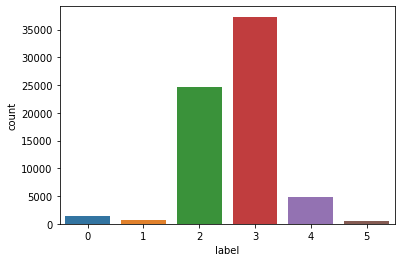

In [19]:
train=train_df.to_pandas()
sns.countplot(x ='label', data = train)

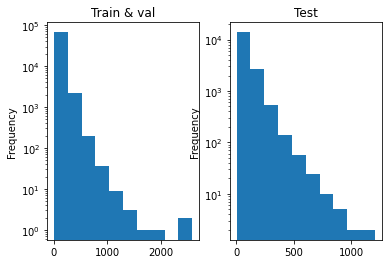

In [21]:
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
train_df['text'].to_pandas().apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Train & val');
plt.subplot(1, 2, 2)
test_df['text'].to_pandas().apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Test');

We can see that test texts are in general shorter.

In [22]:
train_df['text'][0]

'Sam has an everlast treat each nite before bed, like a good tooth brushing. The only downside is finding a place that keeps them in stock as well as multiple flavors.'

**Text Preprocessing**

Steps-

1.Remove Punctuations

2.Remove HTML Tags

3.Convert text to lowercase

4.Remove all special characters

5.Remove stopwords

6.Perform Stemming

7.Join back after stemming

<AxesSubplot:ylabel='id'>

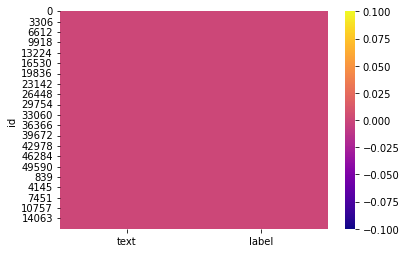

In [23]:
sns.heatmap(train.isnull(),cmap='plasma')

In [24]:
test=test_df.to_pandas()

<AxesSubplot:ylabel='id'>

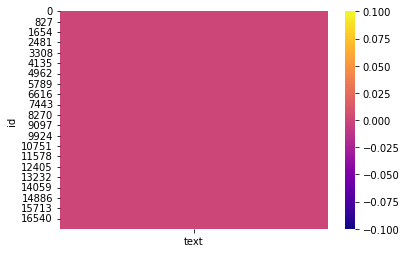

In [25]:
sns.heatmap(test.isnull(),cmap='plasma')

In [26]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
#removing punctuations
train['text']=train['text'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)).lower())
#removing punctuations
test['text']=test['text'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)).lower())

In [28]:
#remove html tags
def clean_html(text):
    clean=re.compile('<.*?>')
    return re.sub(clean,'',text)

In [29]:
train['text']=train['text'].apply(clean_html)
test['text']=test['text'].apply(clean_html)

In [30]:
#convert text to lowercase
def convert_lower(text):
    return text.lower()

In [31]:
train['text']=train['text'].apply(convert_lower)
test['text']=test['text'].apply(convert_lower)

In [32]:
#remove special characters
def remove_special(text):
    x=''
    
    for i in text:
        if i.isalnum():
            x=x+i
        else:
            x=x+' '
    return x

In [33]:
train['text']=train['text'].apply(remove_special)
test['text']=test['text'].apply(remove_special)

In [34]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [35]:
#remove stopwords
def remove_stopwords(text):
    x=[]
    for i in text.split():
        
        if i not in stopwords.words('english'):
            x.append(i)
    
    y=x[:]
    x.clear()
    return y

In [36]:
train['text']=train['text'].apply(remove_stopwords)
test['text']=test['text'].apply(remove_stopwords)

In [37]:
ps=PorterStemmer()

In [38]:
y=[]
#stem the words
def stem_words(text):
    for i in text:
        y.append(ps.stem(i))
    z=y[:]
    y.clear()
    return z

In [39]:
train['text']=train['text'].apply(stem_words)
test['text']=test['text'].apply(stem_words)

In [40]:
#join the stem words together
def join_back(list_input):
    return " ".join(list_input)

In [41]:
train['text']=train['text'].apply(join_back)
test['text']=test['text'].apply(join_back)

In [42]:
X_train =train['text']
y_train = train['label']
tokenize = Tokenizer()
#Tokenize the text
tokenize.fit_on_texts(X_train.values)

In [43]:
X_test = test['text']
X_train = tokenize.texts_to_sequences(X_train)
X_test = tokenize.texts_to_sequences(X_test)

In [44]:
#add padding using pre-method
max_sequence_len = max([len(s.split()) for s in train['text']])
X_train = pad_sequences(X_train, max_sequence_len,padding='pre')
X_test = pad_sequences(X_test, max_sequence_len,padding='pre')

In [45]:
X_train

array([[   0,    0,    0, ...,   14,  789,  584],
       [   0,    0,    0, ...,  314,   42, 1573],
       [   0,    0,    0, ...,   26,   26, 1610],
       ...,
       [   0,    0,    0, ..., 1898,  113,  559],
       [   0,    0,    0, ...,  379,   51,   71],
       [   0,    0,    0, ...,   55,  138, 3967]], dtype=int32)

In [46]:
print(X_train.shape)
print(X_test.shape)

(69410, 1377)
(17353, 1377)


# Machine Learning Models - CUML

I have used the following models -

1.logistic regression - In one-vs-rest logistic regression (OVR) a separate model is trained for each class predicted whether an observation is that class or not (thus making it a binary classification problem). 

2.Random Forests - As the name suggests, "Random Forest is a classifier that contains a number of decision trees on various subsets of the given dataset and takes the average to improve the predictive accuracy of that dataset."

3.Naive Bayes - Naïve Bayes Classifier is one of the simple and most effective Classification algorithms which helps in building the fast machine learning models that can make quick predictions. It is a probabilistic classifier, which means it predicts on the basis of the probability of an object.

**1)logistic regression**

In [47]:
#Calling the model
log_reg = OneVsRestClassifier(LogisticRegression())

In [48]:
#Fitting the model
log_reg.fit(X_train.astype('float32'),y_train.astype('float32'))

[W] [15:31:14.371574] L-BFGS: max iterations reached
[W] [15:31:14.372808] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [15:31:16.892243] L-BFGS: max iterations reached
[W] [15:31:16.893202] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [15:31:17.027478] L-BFGS line search failed (code 4); stopping at the last valid step
[W] [15:31:17.164730] L-BFGS line search failed (code 4); stopping at the last valid step
[W] [15:31:19.745915] L-BFGS: max iterations reached
[W] [15:31:19.746975] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [15:31:22.273433] L-BFGS: max iterations reached
[W] [15:31:

OneVsRestClassifier()

In [49]:
#Making Predictions
y_pred_log_reg = log_reg.predict(X_test.astype('float32'))

In [50]:
y_pred_log_reg=y_pred_log_reg.astype('int32')

In [51]:
y_pred_log_reg

array([3, 3, 3, ..., 3, 3, 3], dtype=int32)

In [52]:
cp.unique(y_pred_log_reg)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [53]:
#Accurcy score
cu_score_log_reg = cuml.metrics.accuracy_score(y_train, y_pred_log_reg )

In [54]:
cu_score_log_reg

0.5384083390235901

In [55]:
#Creating a submission
submission_file =pd.read_csv('/kaggle/input/amazonpetproductsreviews/sample_submission.csv',sep=',')
log_lst=[]
#print(type(log_lst))
#print(type(y_pred_log_reg))
for item in y_pred_log_reg:
    if item==0:
        log_lst.append('birds')
    if item==1:
        log_lst.append('bunny rabbit central')
    if item==2:
        log_lst.append('cats')
    if item==3:
        log_lst.append('dogs')
    if item==4:
        log_lst.append('fish aquatic pets')
    if item==5:
        log_lst.append('small animals')

submission_file['label']=log_lst
submission_file.to_csv('Submission_LogisticRegression.csv',index=False)

**2)Random Forest**

In [56]:
cuml_model = cuRFC(max_features=1.0,
                   n_bins=8,
                   n_estimators=40)

In [57]:
cuml_model.fit(X_train.astype('float32'),y_train.astype('float32'))

RandomForestClassifier()

In [58]:
y_pred_random_forest_classifier = cuml_model.predict(X_test.astype('float32'))

In [59]:
y_pred_random_forest_classifier=y_pred_random_forest_classifier.astype('int32')

In [60]:
y_pred_random_forest_classifier

array([2, 3, 2, ..., 3, 3, 3], dtype=int32)

In [61]:
cp.unique(y_pred_random_forest_classifier)

array([0, 2, 3, 4], dtype=int32)

In [62]:
cu_score_random_forest = cuml.metrics.accuracy_score(y_train, y_pred_random_forest_classifier )

In [63]:
cu_score_random_forest

0.515588104724884

In [64]:
submission_file =pd.read_csv('/kaggle/input/amazonpetproductsreviews/sample_submission.csv',sep=',')
rf_lst=[]
for item in y_pred_random_forest_classifier:
    if item==0:
        rf_lst.append('birds')
    if item==1:
        rf_lst.append('bunny rabbit central')
    if item==2:
        rf_lst.append('cats')
    if item==3:
        rf_lst.append('dogs')
    if item==4:
        rf_lst.append('fish aquatic pets')
    if item==5:
        rf_lst.append('small animals')
submission_file['label']=rf_lst
submission_file.to_csv('Submission_RandomForest.csv',index=False)

**3)Naive Bayes**

In [65]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [66]:
nb_predict=nb.predict(X_test)

In [67]:
nb_predict

array([5, 0, 2, ..., 5, 3, 1], dtype=int32)

In [68]:
cp.unique(nb_predict)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [69]:
cu_score_naive_bayes = cuml.metrics.accuracy_score(y_train, nb_predict )

In [70]:
cu_score_naive_bayes

0.11358266323804855

In [71]:
submission_file =pd.read_csv('/kaggle/input/amazonpetproductsreviews/sample_submission.csv',sep=',')
nb_lst=[]
for item in nb_predict:
    if item==0:
        nb_lst.append('birds')
    if item==1:
        nb_lst.append('bunny rabbit central')
    if item==2:
        nb_lst.append('cats')
    if item==3:
        nb_lst.append('dogs')
    if item==4:
        nb_lst.append('fish aquatic pets')
    if item==5:
        nb_lst.append('small animals')
submission_file['label']=nb_lst
submission_file.to_csv('Submission_NaiveBayes.csv',index=False)

conclusion

cu_score_naive_bayes=0.1135

cu_score_random_forest=0.5155

cu_score_log_reg=0.5384


**What we can try next**

tune hyperparams, those of TfIdfVectorizers as well

add Word2Vec/GloVE/Fasttext embeddings, at least for titles

switch to ULMFiT and other heavy stuff

We can try to use BERT Keras
